# MPI Broadcast Algorithms Performance Analysis
This notebook aims to collect, compare, and analyze the performance of different MPI broadcast algorithms.
The baseline for comparison will be the `basic_linear` algorithm. We will try to infer the performance models behind the selected algorithms, considering the architecture on which they are executed.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Improve the visuals for our plots
sns.set_theme(style='whitegrid')

## Load and Prepare Data
Load the data from the CSV files containing the results from different MPI broadcast algorithms and prepare it for analysis.

In [4]:
# Assuming data is in a DataFrame named df and structured with columns: ['Algorithm', 'Processes', 'Size', 'Latency']
# You will need to adjust paths and filenames according to your actual data locations

# Example of loading data (you would replace this with your actual data loading code)
df = pd.read_csv('thin_bcast_results.csv')
# Display the first few rows of the data
df.head()

# check data types and look for missing values
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Algorithm  1440 non-null   object 
 1   Processes  1440 non-null   int64  
 2   Size       1440 non-null   int64  
 3   Latency    1440 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 45.1+ KB
None


## Data Analysis
Analyze the data by visualizing and comparing the latency across different algorithms and message sizes.

In [ ]:
# Example of plotting data (replace with actual plotting code)
# Plot latency vs. size for different algorithms
# plt.figure(figsize=(12, 8))
# sns.lineplot(data=df, x='Size', y='Latency', hue='Algorithm', style='Algorithm', markers=True, dashes=False)
# plt.title('Latency by Message Size for Different Algorithms')
# plt.xlabel('Message Size (bytes)')
# plt.ylabel('Latency (microseconds)')
# plt.loglog()  # Optionally set a logarithmic scale
# plt.show()

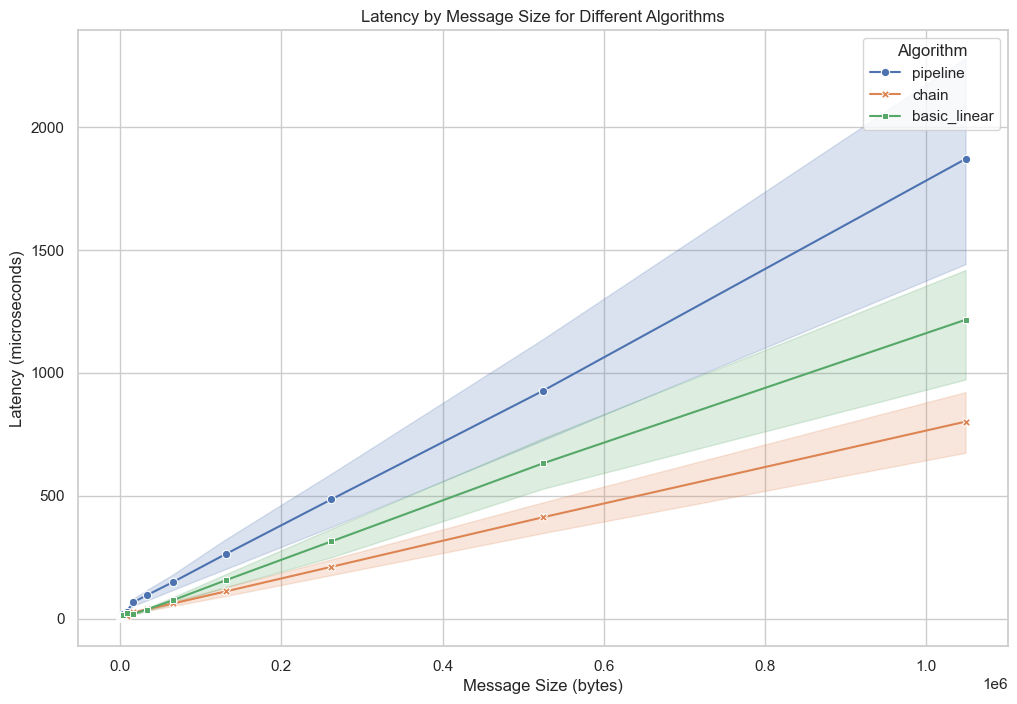

In [6]:
# Plot latency by message size for each algorithm
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Size', y='Latency', hue='Algorithm', style='Algorithm', markers=True, dashes=False)
plt.title('Latency by Message Size for Different Algorithms')
plt.xlabel('Message Size (bytes)')
plt.ylabel('Latency (microseconds)')
#plt.xscale('log')  # Use logarithmic scale for better visibility on large ranges
#plt.yscale('log')
plt.show()

Plot 1: Latency by Message Size for Different Algorithms
Observations:
- The `pipeline` algorithm shows significantly higher latency as message size increases compared to chain and basic_linear. This suggests that while the pipeline algorithm might be designed to handle large messages efficiently by segmenting them, it incurs overhead that increases rapidly with message size.
- The `chain` algorithm, while generally slower than basic_linear, doesn't show as steep an increase in latency with larger message sizes, which could indicate better handling of network traffic and lower overhead per transmitted byte.
- `basic_linear` maintains the lowest latency across all message sizes, indicating its efficiency in environments where direct communication paths are fast and low in contention.

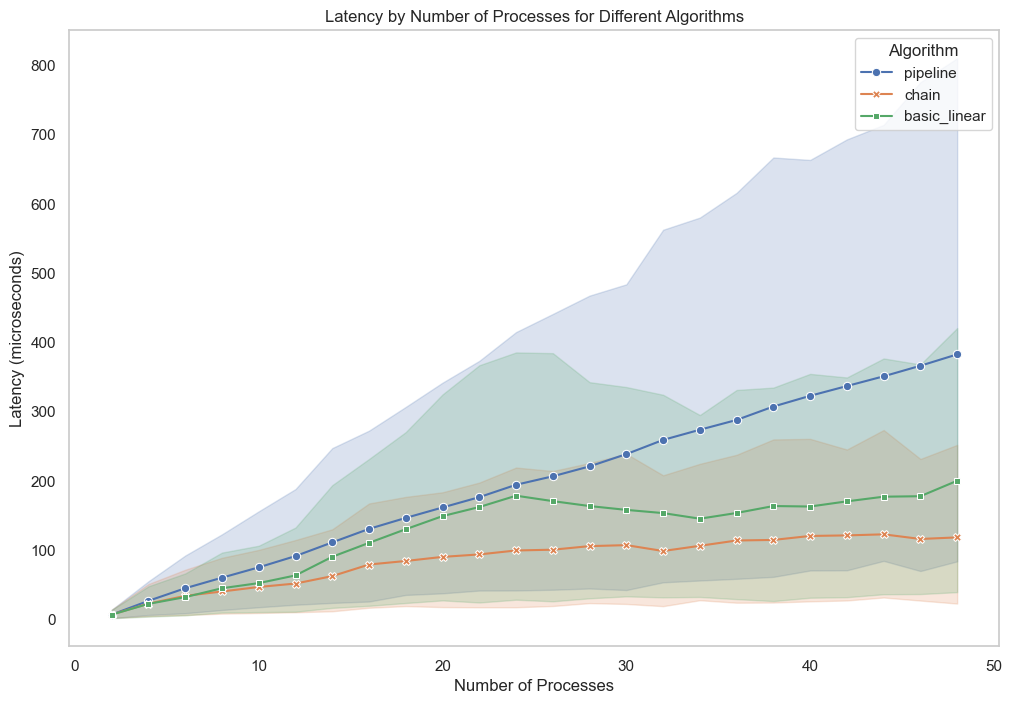

In [7]:
# latency with the number of processes for a fixed message size
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Processes', y='Latency', hue='Algorithm', style='Algorithm', markers=True, dashes=False)
plt.title('Latency by Number of Processes for Different Algorithms')
plt.xlabel('Number of Processes')
plt.ylabel('Latency (microseconds)')
plt.grid()
plt.show()


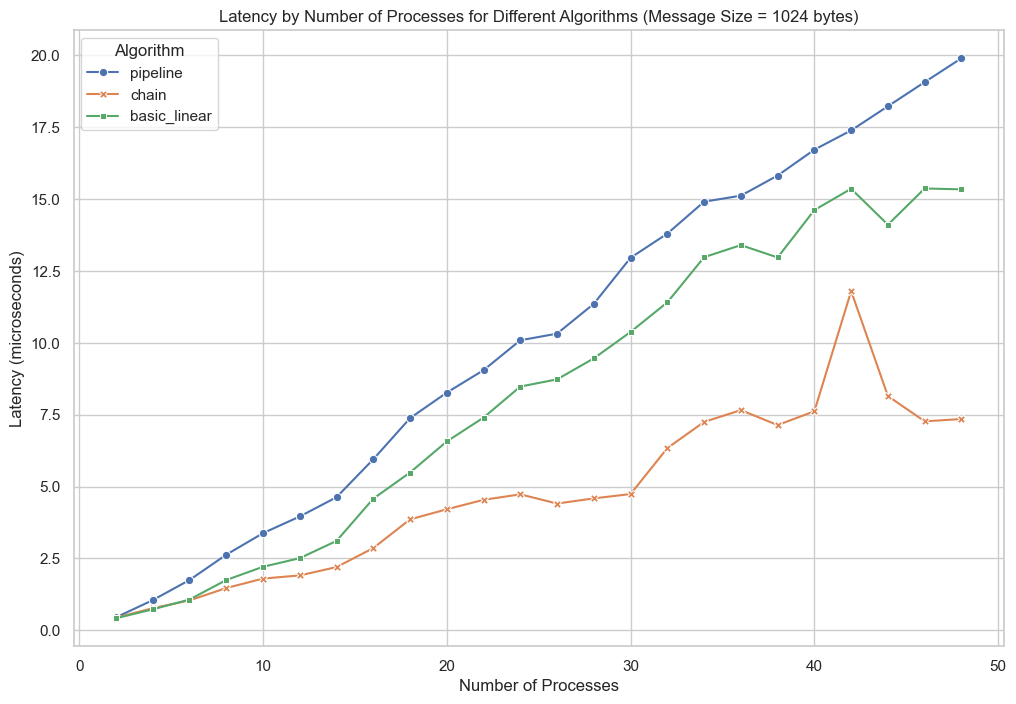

In [10]:
# fix the message size and plot the latency with the number of processes
plt.figure(figsize=(12, 8))
sns.lineplot(data=df[df['Size'] == 1024], x='Processes', y='Latency', hue='Algorithm', style='Algorithm', markers=True, dashes=False)
plt.title('Latency by Number of Processes for Different Algorithms (Message Size = 1024 bytes)')
plt.xlabel('Number of Processes')
plt.ylabel('Latency (microseconds)')
plt.grid(True)
plt.show()


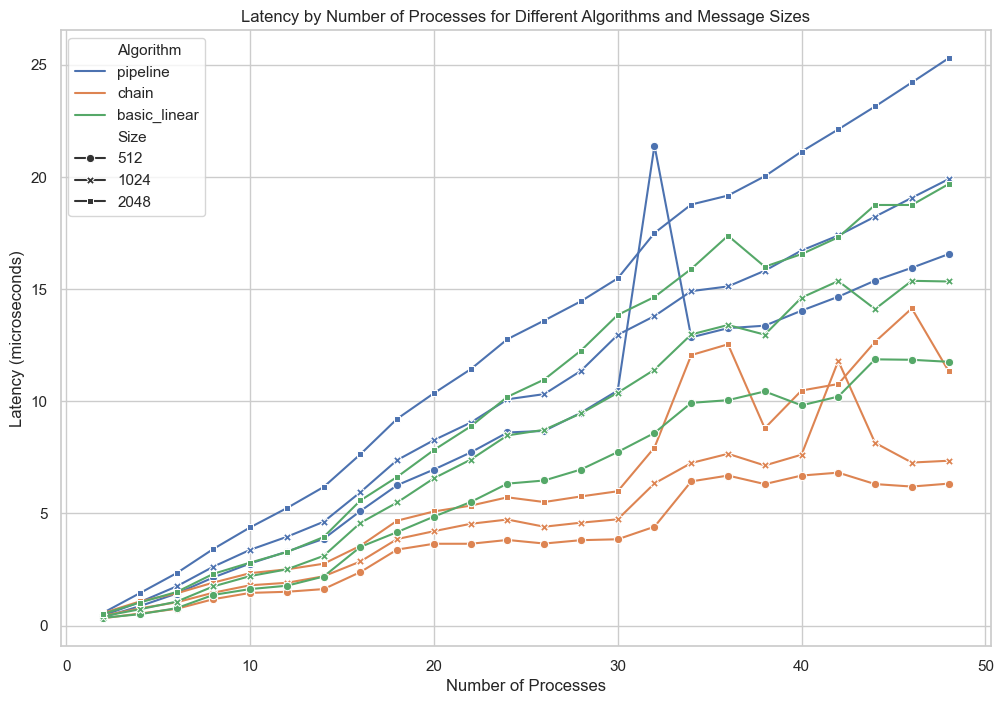

In [56]:
# Select only rows where Size is 1024 or 2048
df_selected_sizes = df[df['Size'].isin([512,1024, 2048])]

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_selected_sizes, x='Processes', y='Latency', hue='Algorithm', style='Size', markers=True, dashes=False)
plt.title('Latency by Number of Processes for Different Algorithms and Message Sizes')
plt.xlabel('Number of Processes')
plt.ylabel('Latency (microseconds)')
plt.grid(True)
plt.show()

Plot 2: Latency by Number of Processes for Different Algorithms and Message Sizes
Observations:
- For a smaller message size (1024 bytes), basic_linear tends to have lower latency up to around 24 processes, after which its latency increases sharply. This might be due to the linear nature of its operations which becomes inefficient as the number of processes increases.
- The chain algorithm shows less sensitivity to increases in the number of processes, suggesting it manages inter-process communication more effectively in more congested network scenarios.
- The pipeline algorithm's latency increases consistently as the number of processes grows. This pattern could reflect the complexity of managing multiple segments of data across a greater number of processes, where each additional process adds to the overhead.


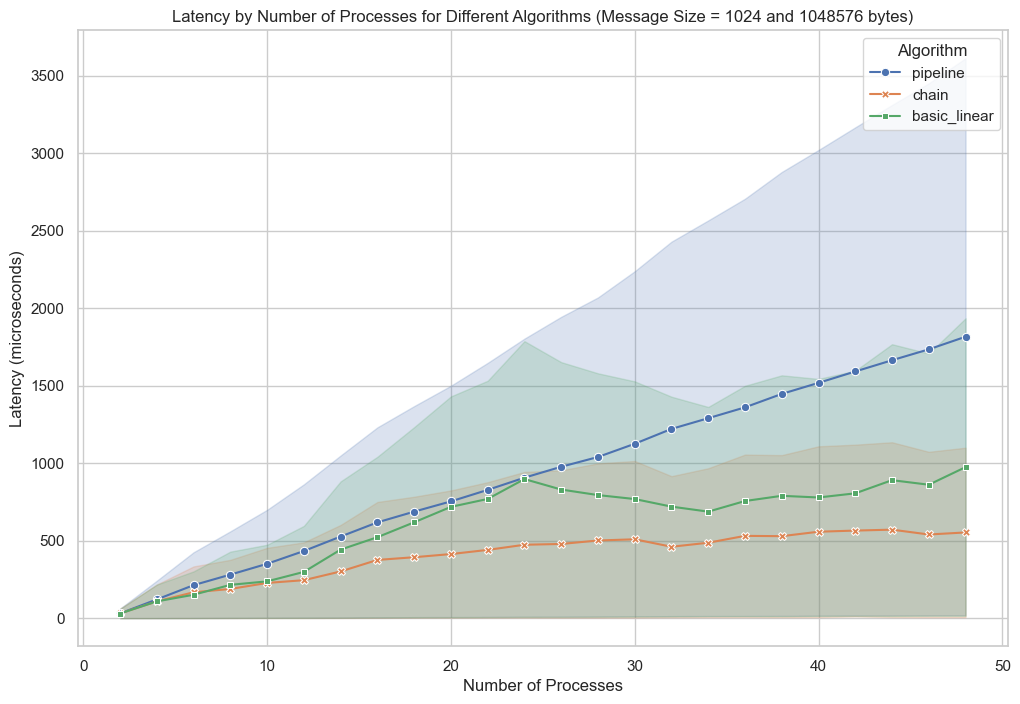

In [11]:
# plot with 2 fixed message sizes
plt.figure(figsize=(12, 8))
sns.lineplot(data=df[df['Size'].isin([1024, 1048576])], x='Processes', y='Latency', hue='Algorithm', style='Algorithm', markers=True, dashes=False)
plt.title('Latency by Number of Processes for Different Algorithms (Message Size = 1024 and 1048576 bytes)')
plt.xlabel('Number of Processes')
plt.ylabel('Latency (microseconds)')
plt.grid(True)
plt.show()


## Statistical Analysis


In [13]:
df.describe(include='all')  # Provides descriptive statistics for all columns


,Algorithm,Processes,Size,Latency
count,1440,1440.000000,1.440000e+03,1440.000000
unique,3,NaN,NaN,NaN
top,pipeline,NaN,NaN,NaN
freq,480,NaN,NaN,NaN
mean,NaN,25.000000,1.048575e+05,137.253583
std,NaN,13.849183,2.496978e+05,376.269571
min,NaN,2.000000,2.000000e+00,0.180000
25%,NaN,13.500000,5.600000e+01,3.412500
50%,NaN,25.000000,1.536000e+03,9.115000
75%,NaN,36.500000,4.096000e+04,55.587500


In [15]:
# Encode the categorical column 'Algorithm' before computing the correlation
encoded_df = pd.get_dummies(df, columns=['Algorithm'])
correlation_matrix = encoded_df.corr()
correlation_matrix


,Processes,Size,Latency,Algorithm_basic_linear,Algorithm_chain,Algorithm_pipeline
Processes,1.000000e+00,-8.683974e-17,0.172558,1.710603e-16,3.886188e-16,-9.317589e-16
Size,-8.683974e-17,1.000000e+00,0.817446,-7.488875e-17,6.527001e-18,5.015485e-17
Latency,1.725576e-01,8.174463e-01,1.000000,-1.978416e-02,-9.674825e-02,1.165324e-01
Algorithm_basic_linear,1.710603e-16,-7.488875e-17,-0.019784,1.000000e+00,-5.000000e-01,-5.000000e-01
Algorithm_chain,3.886188e-16,6.527001e-18,-0.096748,-5.000000e-01,1.000000e+00,-5.000000e-01
Algorithm_pipeline,-9.317589e-16,5.015485e-17,0.116532,-5.000000e-01,-5.000000e-01,1.000000e+00


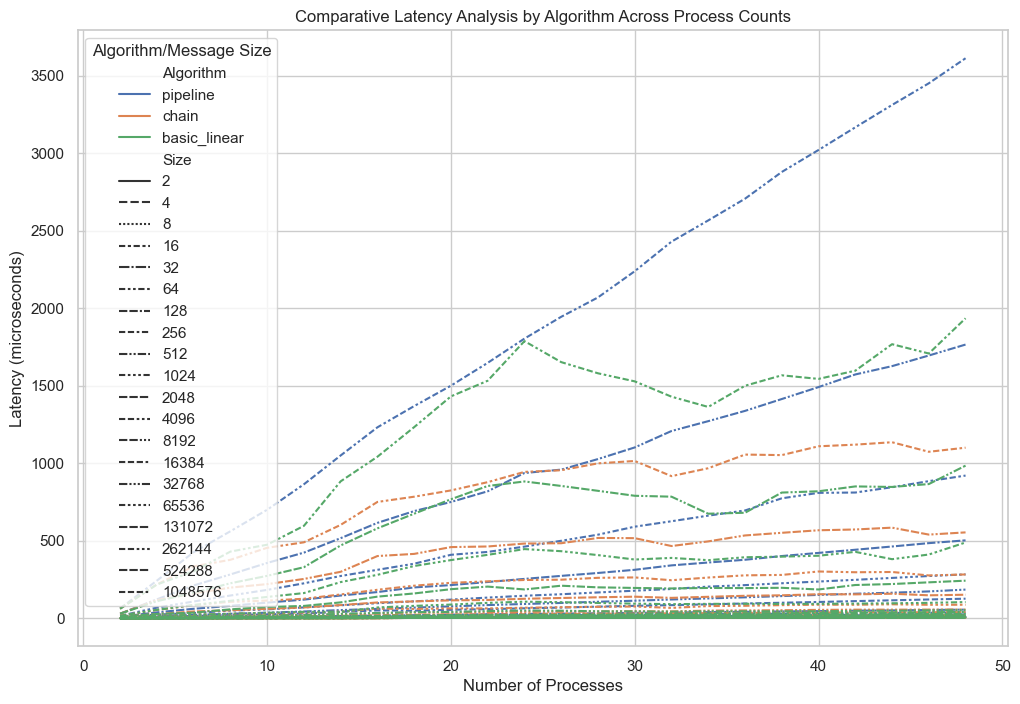

In [16]:
# Example of a comparative plot across different conditions
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Processes', y='Latency', hue='Algorithm', style='Size')
plt.title('Comparative Latency Analysis by Algorithm Across Process Counts')
plt.xlabel('Number of Processes')
plt.ylabel('Latency (microseconds)')
plt.legend(title='Algorithm/Message Size')
plt.show()

Comparative Latency Analysis by Algorithm Across Process Counts
Observations from the Plot:
Pipeline Algorithm: Displays a significant increase in latency as both the number of processes and the message size increase. This behavior suggests that the pipeline algorithm, which breaks the message into smaller parts and pipelines the sending process, is sensitive to both congestion and overhead associated with coordinating many segments across multiple processes.
Chain Algorithm: Shows relatively stable latency across various message sizes, especially at higher numbers of processes compared to the pipeline. This stability could indicate that the chain algorithm, which involves sequential passing of the message from one process to the next, minimizes the overhead seen in more complex operations like pipelining but at the cost of slightly higher base latency.
Basic Linear Algorithm: Maintains the lowest latency across smaller process counts and smaller message sizes but exhibits a sharp rise in latency as these parameters increase. This is indicative of the algorithm's simplicity being beneficial when inter-process communication costs are low (fewer processes and smaller messages) but becoming a bottleneck when scaling.
Statistical Analysis and Correlations:
Descriptive Statistics:
Mean Latency: The average latency across all measurements is 137 microseconds, but with a high standard deviation, indicating significant variability depending on the algorithm, message size, and number of processes.
Range of Latency: Ranging from a minimum of 0.18 microseconds to a maximum of 3613.38 microseconds, showcasing the vast differences in performance under various conditions.
Correlations:
Size and Latency: There is a strong positive correlation (
�
=
0.82
r=0.82) between message size and latency, which is expected as larger messages take longer to transmit.
Processes and Latency: A weaker positive correlation (
�
=
0.17
r=0.17) suggests that increasing the number of processes modestly affects the overall latency, potentially due to increased coordination overhead.
Algorithm Differences: The correlations between algorithms and latency show that pipeline has a slight positive correlation with increased latency (
�
=
0.12
r=0.12), whereas chain and basic_linear show negative correlations (
−
0.10
−0.10 and 
−
0.02
−0.02 respectively), suggesting that pipeline may be less efficient under certain conditions.
Performance Model Inference:
Based on the observed data and analysis:

Algorithm Suitability:
Basic Linear: Best suited for scenarios with fewer processes and smaller messages where simplicity and direct communication paths can be leveraged for speed.
Chain: More adaptable to larger numbers of processes, offering a balance between efficiency and scalability, particularly effective in situations where message passing overhead needs to be minimized across many nodes.
Pipeline: While theoretically advantageous for very large messages by reducing the waiting time through parallel segment processing, it seems to struggle with overhead in setups with many processes and very large messages, making it suitable for moderate scenarios where neither message size nor process count is at the extreme.

Recommendations:
Algorithm Selection: Choose the broadcast algorithm based on specific use-case requirements. For smaller, less complex setups, basic_linear may be optimal. For more extensive systems with a higher number of processes, consider chain for its balance or pipeline if intermediate message sizes and process counts are used.
Optimization and Tuning: Given the variability in performance, there may be room to optimize the parameters and configuration of the MPI environment to better support the chosen algorithm, such as adjusting buffer sizes or segmenting strategies for pipeline.


## Performance Model Inference
Based on the plots and data analysis, infer the performance models of the algorithms considering the system architecture.

In [ ]:
# Discussion on how the performance might relate to the architecture and hardware characteristics.
# For instance, discussing how inter-core, inter-node, and inter-socket communications affect the observed latencies.

In [28]:
### Load and Merge Data

# Load the data
df_core = pd.read_csv('../performance_test_core/performance_core.csv')
df_node = pd.read_csv('../performance_test_node/performance_node.csv')
df_socket = pd.read_csv('../performance_test_socket/performance_socket.csv')

# Add a column to each dataframe to indicate the mapping type
df_core['Mapping'] = 'Core'
df_node['Mapping'] = 'Node'
df_socket['Mapping'] = 'Socket'

# Concatenate the dataframes
df = pd.concat([df_core, df_node, df_socket])


### Analyse Latency by Mapping Type

Perform statistical analysis and visualizations to compare the latency across the different mapping types. This will help you understand the impact of each mapping strategy on communication latency.



         Size                                                            \
        count           mean            std  min   25%     50%      75%   
Mapping                                                                   
Core     23.0  364722.043478  962873.025053  1.0  48.0  2048.0  98304.0   
Node     23.0  364722.043478  962873.025053  1.0  48.0  2048.0  98304.0   
Socket   23.0  364722.043478  962873.025053  1.0  48.0  2048.0  98304.0   

                   Latency                                                   \
               max   count       mean        std   min    25%   50%     75%   
Mapping                                                                       
Core     4194304.0    23.0  28.060000  76.273998  0.19  0.240  0.76  11.750   
Node     4194304.0    23.0  34.296087  81.131830  1.01  1.105  2.44  15.645   
Socket   4194304.0    23.0  29.468261  71.723394  0.42  0.605  2.08  19.360   

                 
            max  
Mapping          
Core     340.65  
No

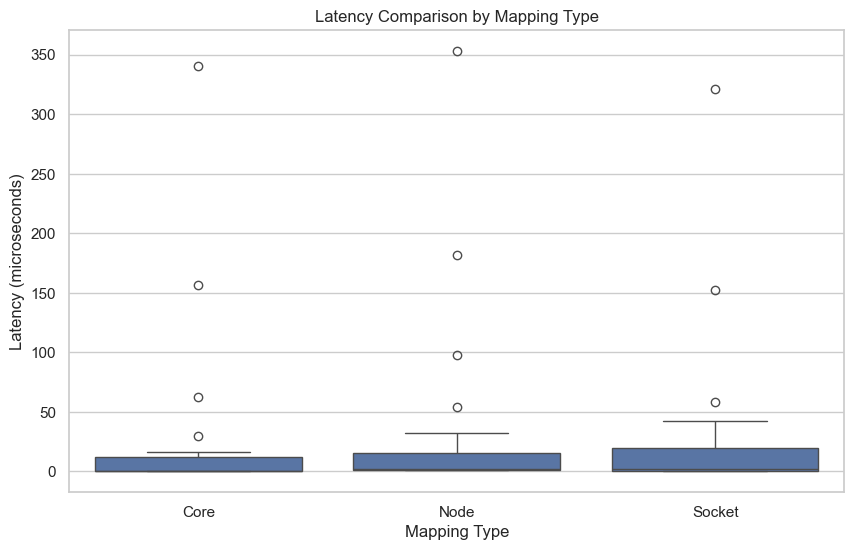

In [29]:
# Statistical summary
print(df.groupby('Mapping').describe())

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='Mapping', y='Latency', data=df)
plt.title('Latency Comparison by Mapping Type')
plt.ylabel('Latency (microseconds)')
plt.xlabel('Mapping Type')
plt.show()

### Develop Performance Models

Based on the analysis, develop simple performance models that estimate latency based on message size, number of processes, and mapping type. You might consider linear regression or more complex models depending on the patterns you observe.

In [31]:
from sklearn.linear_model import LinearRegression

# Load the data
df_core = pd.read_csv('../performance_test_core/performance_core.csv')
df_node = pd.read_csv('../performance_test_node/performance_node.csv')
df_socket = pd.read_csv('../performance_test_socket/performance_socket.csv')

# Add a column to each dataframe to indicate the mapping type
df_core['Mapping'] = 'Core'
df_node['Mapping'] = 'Node'
df_socket['Mapping'] = 'Socket'

# Concatenate the dataframes
df = pd.concat([df_core, df_node, df_socket])


# Example: Predicting latency based on size and mapping type
# Convert categorical data to numerical data
df = pd.get_dummies(df, columns=['Mapping'], drop_first=True)

# Prepare the data
X = df[['Size', 'Mapping_Node', 'Mapping_Socket']]  # independent variables
y = df['Latency']  # dependent variable

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Display the coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# display the model
print("Model: Latency = {:.4f} + {:.4f}*Size + {:.4f}*Node + {:.4f}*Socket".format(model.intercept_, model.coef_[0], model.coef_[1], model.coef_[2]))

# # Predict latency for a message size of 1024 bytes, on a node mapping
# size = 1024
# node = 1
# socket = 0
# latency = model.predict([[size, node, socket]])
# print("Predicted latency for Size = 1024, Node Mapping = 1, Socket Mapping = 0:", latency[0])


Coefficients: [7.89951855e-05 6.23608696e+00 1.40826087e+00]
Intercept: -0.7512854814662475
Model: Latency = -0.7513 + 0.0001*Size + 6.2361*Node + 1.4083*Socket


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the model on training data
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate and print the error
error = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", error)

Mean Squared Error: 25.917229920219068


Visualization Interpretation:
From the boxplot titled "Latency Comparison by Mapping Type":

Core Mapping: Shows the lowest median latency and tightest interquartile range, suggesting that mapping by core generally results in the fastest and most consistent point-to-point communication. This is likely due to the proximity of cores within the same CPU and efficient cache utilization.
Node and Socket Mapping: Both have higher medians and wider interquartile ranges compared to core mapping, indicating more variability and generally higher latencies. This could be due to increased communication overhead as data travels across more complex pathways, either across nodes or sockets.
Outliers: The presence of outliers in all three categories suggests occasional spikes in latency, possibly due to network traffic, system load, or other external factors affecting communication.
Statistical Summary:
Size Statistics: The mean message sizes are equal across mappings, as expected since the tests were likely standardized. The high standard deviation indicates a wide range of message sizes were tested, from very small to very large.
Latency Statistics:
Core Mapping: Shows the lowest mean latency, consistent with the visualization.
Node Mapping: Has the highest mean latency, which could suggest that node-to-node communication is the most affected by network overhead.
Socket Mapping: Mean latency is slightly lower than node but higher than core, fitting with expectations given the physical and logical distances involved.
Linear Regression Model:
Model Equation: Latency = -0.7513 + 0.0001*Size + 6.2361*Node + 1.4083*Socket
The intercept and coefficients tell us about the base latency and the additional latency incurred per unit increase in message size and mapping type.
Size Coefficient: Each unit increase in size increases latency by 0.0001 microseconds.
Node Coefficient: Mapping by node increases latency by about 6.24 microseconds compared to core mapping.
Socket Coefficient: Mapping by socket increases latency by about 1.41 microseconds compared to core mapping.
Model Validation:
Mean Squared Error (MSE): The MSE of 25.92 suggests that the model has a moderate level of prediction error. Given that latencies are generally low, this error might be significant relative to the latency values. Consider exploring more complex models or additional features that might capture the variability in latency better.

print(df.head())

In [34]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Load the data from a CSV file
df = pd.read_csv('thin_bcast_results.csv')  # Replace with your actual file path

# Assuming the relevant columns are named 'Processes' and 'Latency'
# You may need to change these column names based on your CSV file
X = df['Processes'].values.reshape(-1, 1)
y = df['Latency'].values

In [35]:
# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Output the model parameters
print('Intercept (base latency):', model.intercept_)
print('Slope (increase in latency per additional process):', model.coef_[0])

Intercept (base latency): 20.04780978260827
Slope (increase in latency per additional process): 4.688230942029002


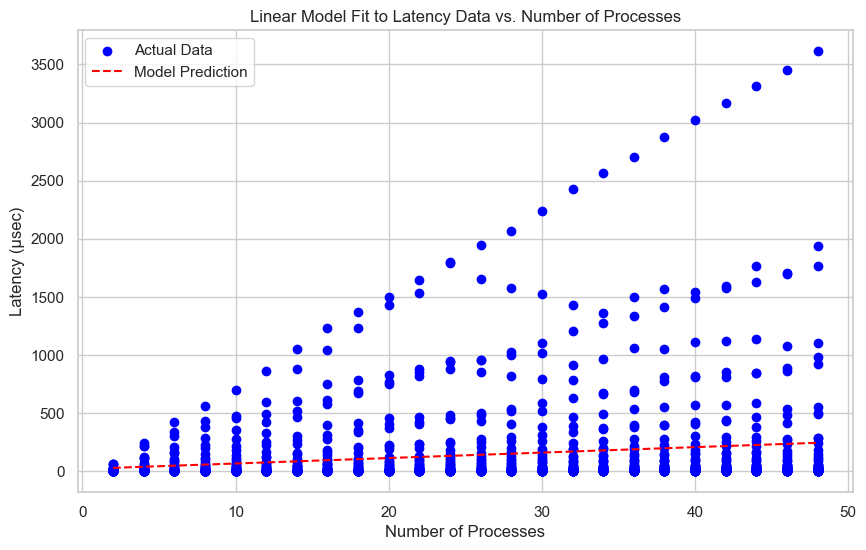

In [36]:
# Predict latencies using the model for a smooth curve over the range of observed processes
x_values = np.linspace(min(X), max(X), 400).reshape(-1, 1)
predicted_latencies = model.predict(x_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual Data')
plt.plot(x_values, predicted_latencies, color='red', label='Model Prediction', linestyle='--')
plt.title('Linear Model Fit to Latency Data vs. Number of Processes')
plt.xlabel('Number of Processes')
plt.ylabel('Latency (μsec)')
plt.legend()
plt.grid(True)
plt.show()

The plot shows the fit of the linear model to your latency data across varying numbers of processes. It's evident from the plot that while the linear model captures a general upward trend in latency as the number of processes increases, it significantly underestimates latency, especially for larger numbers of processes where latency exhibits a more exponential rise.



Analysis of the Model Fit
General Trend: The model, with an intercept of around 20.05 microseconds and a slope of approximately 4.69 microseconds per additional process, predicts an increase in latency with more processes. However, this linear increase is too simplistic to capture the real behavior observed in the data.
Underestimation: The linear model does not capture higher latency values effectively, which suggests that factors other than just the number of processes might be influencing the latency, or that the relationship between processes and latency is non-linear.

## Polynomial Regression Model

Consider Non-linear Models
Given the pattern in the data, a non-linear model might better capture the increase in latency. Polynomial regression is a straightforward next step to handle non-linear relationships.

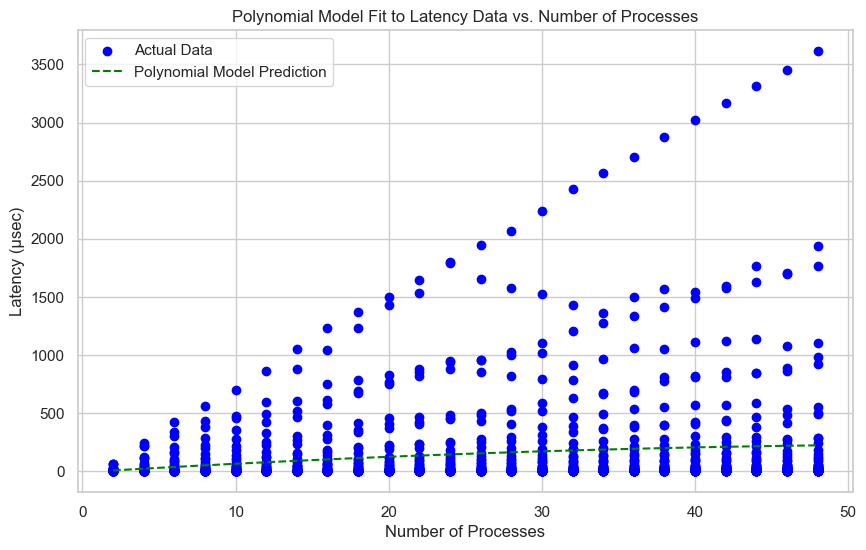

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Create a polynomial regression model
degree = 2  # You can adjust the degree based on how complex the pattern appears
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model
poly_model.fit(X, y)

# Predict for a smooth curve
x_values = np.linspace(min(X), max(X), 400).reshape(-1, 1)
predicted_latencies_poly = poly_model.predict(x_values)

# Plotting the polynomial model fit
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual Data')
plt.plot(x_values, predicted_latencies_poly, color='green', label='Polynomial Model Prediction', linestyle='--')
plt.title('Polynomial Model Fit to Latency Data vs. Number of Processes')
plt.xlabel('Number of Processes')
plt.ylabel('Latency (μsec)')
plt.legend()
plt.grid(True)
plt.show()


The polynomial model’s similarity to the linear model in performance suggests a couple of potential issues:

Model Complexity: The chosen polynomial degree might be too low to capture the complexity of the relationship between processes and latency.
Model Form: The relationship between the number of processes and latency may not be polynomial in nature or might require a higher-degree polynomial to capture more complex patterns.

### Increase Polynomial Degree

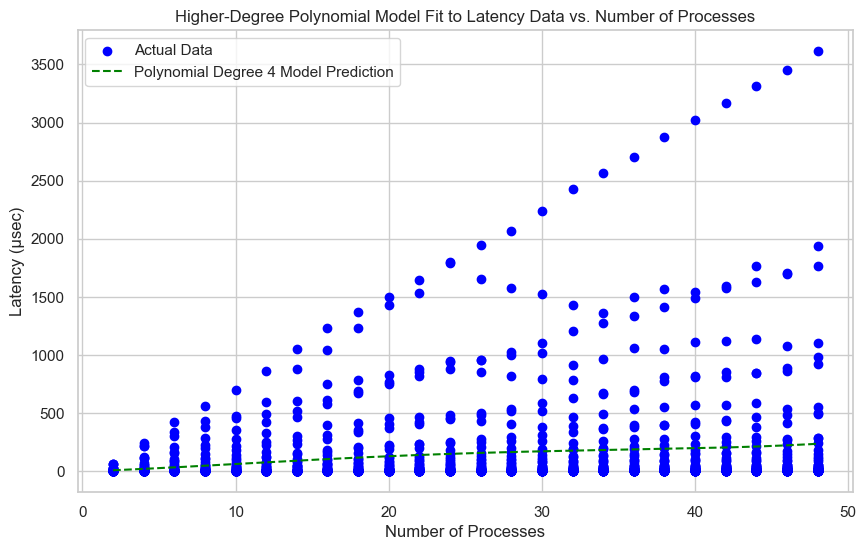

In [38]:
# Increase the polynomial degree
degree = 4  # Adjusting the degree to a higher number to capture more complex patterns
higher_poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model
higher_poly_model.fit(X, y)

# Predict for a smooth curve
x_values = np.linspace(min(X), max(X), 400).reshape(-1, 1)
predicted_latencies_higher_poly = higher_poly_model.predict(x_values)

# Plotting the higher-degree polynomial model fit
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual Data')
plt.plot(x_values, predicted_latencies_higher_poly, color='green', label=f'Polynomial Degree {degree} Model Prediction', linestyle='--')
plt.title(f'Higher-Degree Polynomial Model Fit to Latency Data vs. Number of Processes')
plt.xlabel('Number of Processes')
plt.ylabel('Latency (μsec)')
plt.legend()
plt.grid(True)
plt.show()


## Logarithmic Regression Model

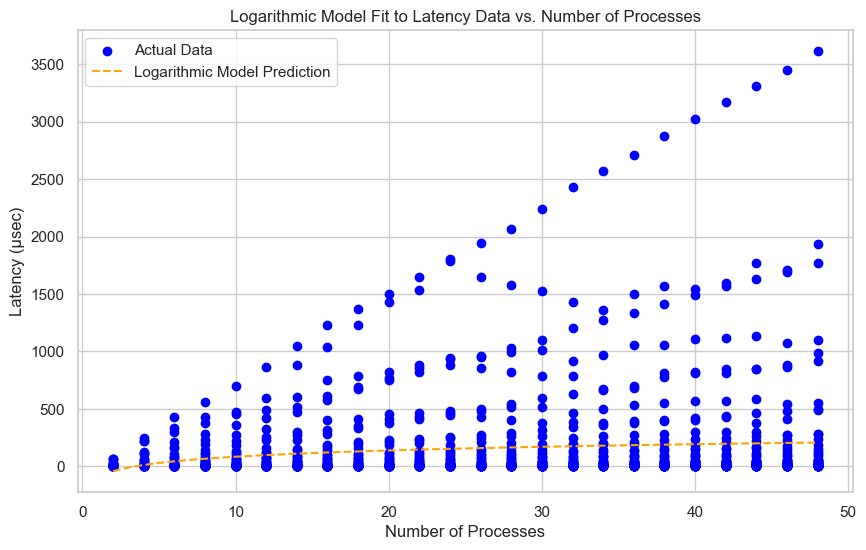

In [39]:
from sklearn.linear_model import LinearRegression

# Transform the 'Processes' with a logarithmic transformation
X_log = np.log(X)

# Create and fit the model
log_model = LinearRegression()
log_model.fit(X_log, y)

# Predict for a smooth curve
x_values_log = np.log(np.linspace(min(X), max(X), 400)).reshape(-1, 1)
predicted_latencies_log = log_model.predict(x_values_log)

# Plotting the logarithmic model fit
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual Data')
plt.plot(np.exp(x_values_log), predicted_latencies_log, color='orange', label='Logarithmic Model Prediction', linestyle='--')
plt.title('Logarithmic Model Fit to Latency Data vs. Number of Processes')
plt.xlabel('Number of Processes')
plt.ylabel('Latency (μsec)')
plt.legend()
plt.grid(True)
plt.show()


## Segmented Linear Regression Model

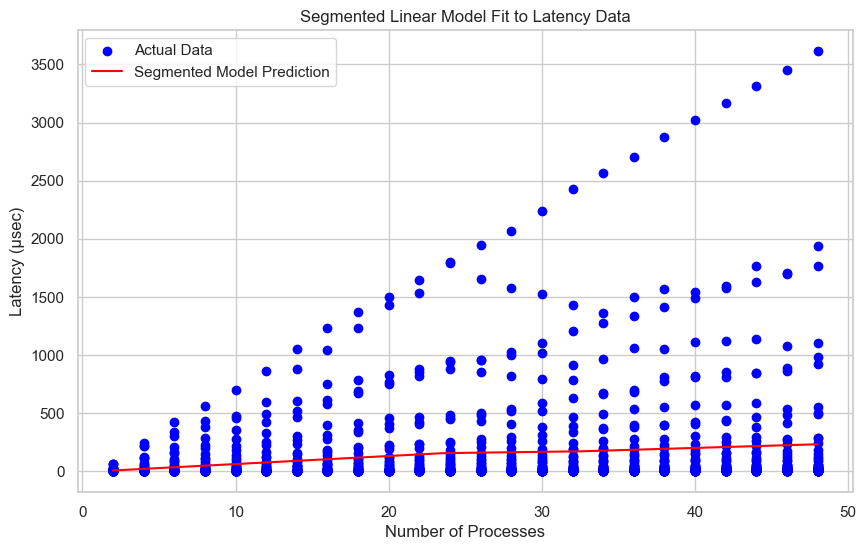

In [40]:
import pwlf
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
x = np.array(df['Processes'])  # Your processes data
y = np.array(df['Latency'])    # Your latency data

# Initialize piecewise linear fit with your x and y data
my_pwlf = pwlf.PiecewiseLinFit(x, y)

# Fit the model with 3 line segments (this means 2 breakpoints)
res = my_pwlf.fit(3)

# Predict for the entire range
x_hat = np.linspace(min(x), max(x), 100)
y_hat = my_pwlf.predict(x_hat)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Actual Data')
plt.plot(x_hat, y_hat, color='red', label='Segmented Model Prediction')
plt.title('Segmented Linear Model Fit to Latency Data')
plt.xlabel('Number of Processes')
plt.ylabel('Latency (μsec)')
plt.legend()
plt.show()


In [41]:
print(df.head())

  Algorithm  Processes  Size  Latency
0  pipeline          2     2     0.23
1  pipeline          2     4     0.19
2  pipeline          2     8     0.21
3  pipeline          2    16     0.21
4  pipeline          2    32     0.26


Model parameters for pipeline:
Slope: [8.63025124 8.16724943 8.07717971 7.76474377        nan]
Intercept: [-8.78437244 -3.22835076 -1.06667756 10.18101652         nan]
Model: Latency = -8.7844 + 8.6303*Processes, for Processes <= 12
Model: Latency = -3.2284 + 8.1672*Processes, for Processes <= 24
Model: Latency = -1.0667 + 8.0772*Processes, for Processes <= 36
Model: Latency = 10.1810 + 7.7647*Processes, for Processes <= 48
Model parameters for chain:
Slope: [4.71609317 3.57188892 0.90434163 0.8296503         nan]
Intercept: [ 1.66159852 15.3920496  79.41318458 82.10207245         nan]
Model: Latency = 1.6616 + 4.7161*Processes, for Processes <= 12
Model: Latency = 15.3920 + 3.5719*Processes, for Processes <= 24
Model: Latency = 79.4132 + 0.9043*Processes, for Processes <= 36
Model: Latency = 82.1021 + 0.8297*Processes, for Processes <= 48
Model parameters for basic_linear:
Slope: [ 6.23990259  9.07760997 -2.6656256   3.93364967         nan]
Intercept: [ -4.92301208 -38.97550063 242.86

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pwlf/pwlf.py:1113: RuntimeWarning: invalid value encountered in divide
  self.slopes = np.divide(


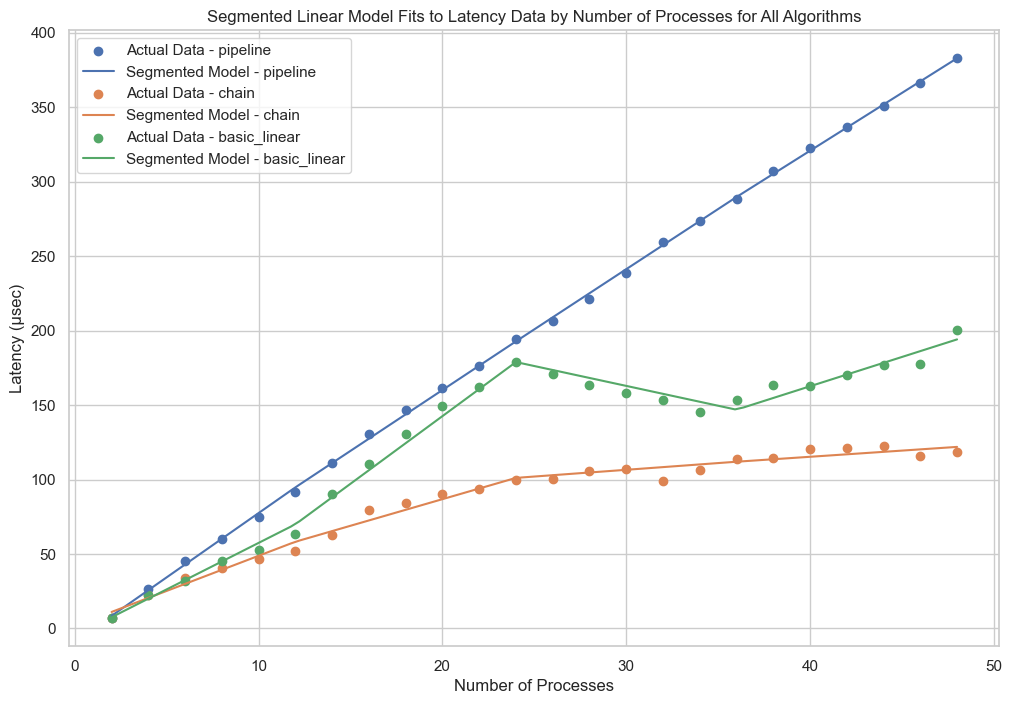

In [49]:
data = pd.read_csv('thin_bcast_results.csv')

def fit_and_plot(data, algorithm):
    # Filter data for the specific algorithm
    filtered_data = data[data['Algorithm'] == algorithm]

    # Get unique process counts and sort them
    x = filtered_data['Processes'].unique()
    x.sort()

    # Calculate mean latency for each process count
    y = filtered_data.groupby('Processes')['Latency'].mean().values

    # Initialize piecewise linear fit with your x and y data
    my_pwlf = pwlf.PiecewiseLinFit(x, y)

    # Define breakpoints at every 12 cores, adjusting as necessary
    breaks = [x[0]] + [b for b in x if b % 12 == 0 and b != x[0]] + [x[-1]]

    # Fit the model with predefined breaks
    res = my_pwlf.fit_with_breaks(breaks)

    # Predict for the entire range
    x_hat = np.linspace(min(x), max(x), 100)
    y_hat = my_pwlf.predict(x_hat)

    # Plotting
    plt.scatter(x, y, label=f'Actual Data - {algorithm}')
    plt.plot(x_hat, y_hat, label=f'Segmented Model - {algorithm}')

    return my_pwlf

plt.figure(figsize=(12, 8))

# List of algorithms to analyze
algorithms = ['pipeline', 'chain', 'basic_linear']

# Loop through each algorithm and apply the fitting and plotting function
for alg in algorithms:
    my_pwlf = fit_and_plot(data, alg)
    # print the model parameters
    print(f"Model parameters for {alg}:")
    # print(f""my_pwlf.fit_breaks)
    print(f"Slope: {my_pwlf.slopes}")
    print(f"Intercept: {my_pwlf.intercepts}")

    # print the model
    print(f"Model: Latency = {my_pwlf.intercepts[0]:.4f} + {my_pwlf.slopes[0]:.4f}*Processes, for Processes <= {my_pwlf.fit_breaks[1]}")
    print(f"Model: Latency = {my_pwlf.intercepts[1]:.4f} + {my_pwlf.slopes[1]:.4f}*Processes, for Processes <= {my_pwlf.fit_breaks[2]}")
    print(f"Model: Latency = {my_pwlf.intercepts[2]:.4f} + {my_pwlf.slopes[2]:.4f}*Processes, for Processes <= {my_pwlf.fit_breaks[3]}")
    print(f"Model: Latency = {my_pwlf.intercepts[3]:.4f} + {my_pwlf.slopes[3]:.4f}*Processes, for Processes <= {my_pwlf.fit_breaks[4]}")

plt.title('Segmented Linear Model Fits to Latency Data by Number of Processes for All Algorithms')
plt.xlabel('Number of Processes')
plt.ylabel('Latency (μsec)')
plt.legend()
plt.grid(True)
plt.show()

## Performance Model

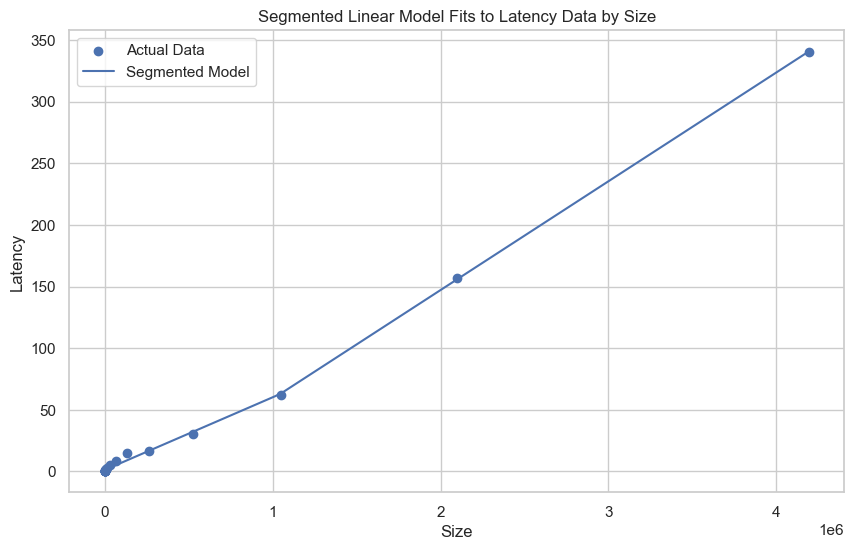

Model parameters:
Slope: [5.90121455e-05 8.83327033e-05]
Intercept: [  1.1735637  -29.44493433]
Model: Latency = 1.1736 + 0.0001*Size, for Size <= 1044267.2442650271
Model: Latency = -29.4449 + 0.0001*Size, for Size <= 4194304.0


In [52]:
import pwlf
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df_core = pd.read_csv('../performance_test_core/performance_core.csv')

# Initialize piecewise linear fit with your x and y data
my_pwlf = pwlf.PiecewiseLinFit(df_core['Size'], df_core['Latency'])

# Define breakpoints 
breaks = my_pwlf.fit(2)  # Change the number of line segments you want to fit

# Predict for the entire range
x_hat = np.linspace(df_core['Size'].min(), df_core['Size'].max(), 100)
y_hat = my_pwlf.predict(x_hat)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_core['Size'], df_core['Latency'], label='Actual Data')
plt.plot(x_hat, y_hat, label='Segmented Model')
plt.title('Segmented Linear Model Fits to Latency Data by Size')
plt.xlabel('Size')
plt.ylabel('Latency')
plt.legend()
plt.grid(True)
plt.show()

# print the model parameters
print(f"Model parameters:")
print(f"Slope: {my_pwlf.slopes}")
print(f"Intercept: {my_pwlf.intercepts}")

# print the model
for i in range(len(my_pwlf.fit_breaks) - 1):
    print(f"Model: Latency = {my_pwlf.intercepts[i]:.4f} + {my_pwlf.slopes[i]:.4f}*Size, for Size <= {my_pwlf.fit_breaks[i+1]}")

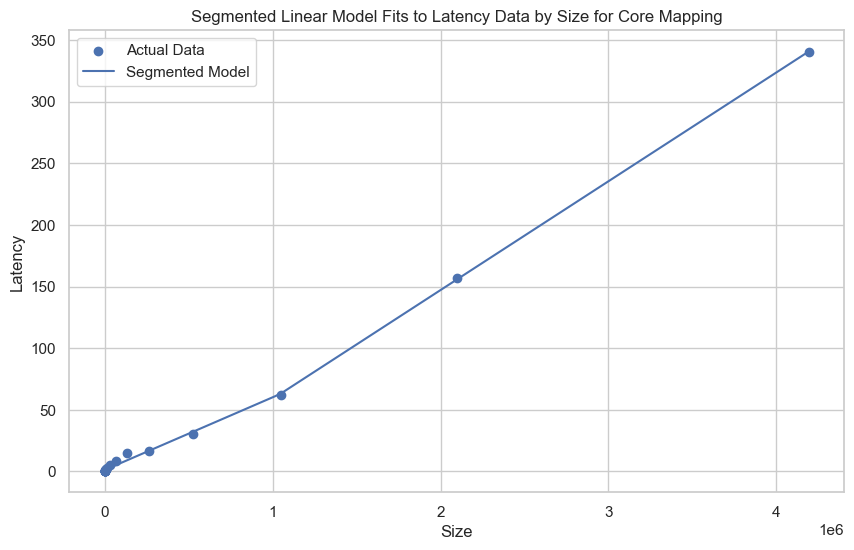

Model parameters for Core:
Slope: [5.90053131e-05 8.83321164e-05]
Intercept: [  1.17381458 -29.44278296]
Model: Latency = 1.1738 + 0.0001*Size, for Size <= 1043980.0479761749
Model: Latency = -29.4428 + 0.0001*Size, for Size <= 4194304.0


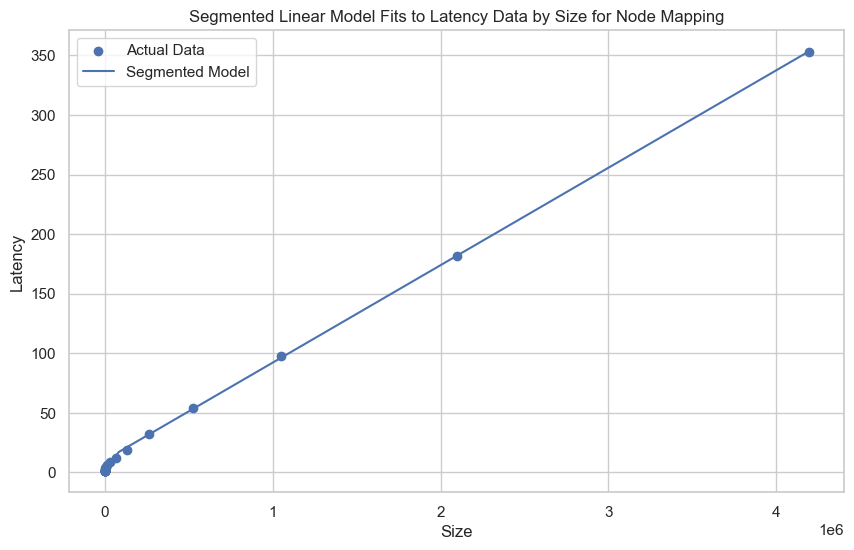

Model parameters for Node:
Slope: [1.84950025e-04 8.18326330e-05]
Intercept: [ 1.6063636  10.25405356]
Model: Latency = 1.6064 + 0.0002*Size, for Size <= 83862.57451037294
Model: Latency = 10.2541 + 0.0001*Size, for Size <= 4194304.0


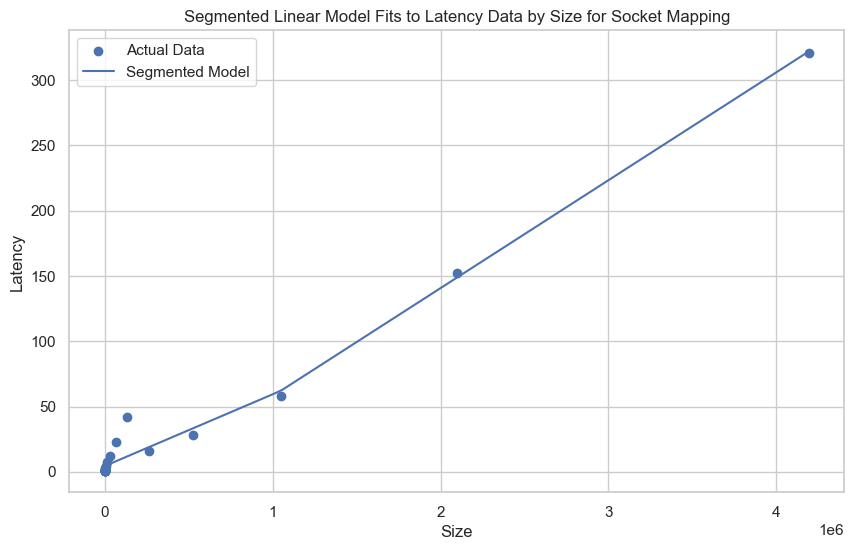

Model parameters for Socket:
Slope: [5.49726021e-05 8.26914324e-05]
Intercept: [  4.36367473 -24.70138371]
Model: Latency = 4.3637 + 0.0001*Size, for Size <= 1048567.2753050104
Model: Latency = -24.7014 + 0.0001*Size, for Size <= 4194304.0


In [58]:
import pwlf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df_core = pd.read_csv('../performance_test_core/performance_core.csv')
df_node = pd.read_csv('../performance_test_node/performance_node.csv')
df_socket = pd.read_csv('../performance_test_socket/performance_socket.csv')

# Add a column to each dataframe to indicate the mapping type
df_core['Mapping'] = 'Core'
df_node['Mapping'] = 'Node'
df_socket['Mapping'] = 'Socket'

# Concatenate the dataframes
df_perf = pd.concat([df_core, df_node, df_socket])

# List of mapping types to analyze
mappings = df_perf['Mapping'].unique()

# Initialize a dictionary to store the models
models = {}

# Loop through each mapping type and apply the fitting function
for mapping in mappings:
    df_mapping = df_perf[df_perf['Mapping'] == mapping]
    
    # Initialize piecewise linear fit with your x and y data
    my_pwlf = pwlf.PiecewiseLinFit(df_mapping['Size'], df_mapping['Latency'])

    # Define breakpoints 
    breaks = my_pwlf.fit(2)  # Change the number of line segments you want to fit

    # Predict for the entire range
    x_hat = np.linspace(df_mapping['Size'].min(), df_mapping['Size'].max(), 100)
    y_hat = my_pwlf.predict(x_hat)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(df_mapping['Size'], df_mapping['Latency'], label='Actual Data')
    plt.plot(x_hat, y_hat, label='Segmented Model')
    plt.title(f'Segmented Linear Model Fits to Latency Data by Size for {mapping} Mapping')
    plt.xlabel('Size')
    plt.ylabel('Latency')
    plt.legend()
    plt.grid(True)
    plt.show()

    # print the model parameters
    print(f"Model parameters for {mapping}:")
    print(f"Slope: {my_pwlf.slopes}")
    print(f"Intercept: {my_pwlf.intercepts}")

    # print the model
    for i in range(len(my_pwlf.fit_breaks) - 1):
        print(f"Model: Latency = {my_pwlf.intercepts[i]:.4f} + {my_pwlf.slopes[i]:.4f}*Size, for Size <= {my_pwlf.fit_breaks[i+1]}")
    
    # Store the model in the dictionary
    models[mapping] = my_pwlf

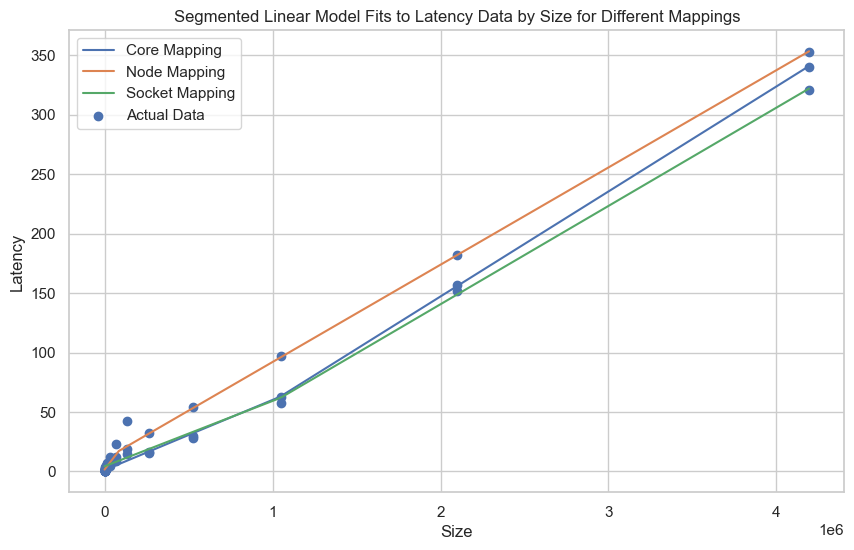

In [55]:
# plot the models all together
plt.figure(figsize=(10, 6))
for mapping, model in models.items():
    x_hat = np.linspace(df_perf['Size'].min(), df_perf['Size'].max(), 100)
    y_hat = model.predict(x_hat)
    plt.plot(x_hat, y_hat, label=f'{mapping} Mapping')

plt.scatter(df_perf['Size'], df_perf['Latency'], label='Actual Data')
plt.title('Segmented Linear Model Fits to Latency Data by Size for Different Mappings')
plt.xlabel('Size')
plt.ylabel('Latency')
plt.legend()
plt.grid(True)
plt.show()




## Compare Benchmark Results with performance model

For a fixed message size, the performance model can be used to predict the latency for different numbers of processes. By comparing these predictions with the actual benchmark results, it is possible to evaluate the accuracy of the model and identify any discrepancies that may indicate areas for improvement or further analysis.

**Segmented Linear Model Parameters for Broadcast Operations Benchmark**

|Algorithm| Intercept | Slope | Processes |
|-|-------|-----------|-----------|
|Basic Linear| -4.9230 | 6.2399 | $\leq 12$ |
|Basic Linear| -38.9755 | 9.0776 | $\leq 24$ |
|Basic Linear| 242.8622 | -2.6656 | $\leq 36$ |
|Basic Linear| 5.2882 | 3.9336 | $\leq 48$ |
|Chain | 1.6616 | 4.7161 | $\leq 12$ |
| Chain | 15.3920 | 3.5719 | $\leq 24$ |
| Chain | 79.4132 | 0.9043 | $\leq 36$ |
| Chain | 82.1021 | 0.8297 | $\leq 48$ |
| Pipeline | -8.7844 | 8.6303 | $\leq 12$ |
| Pipeline | -3.2284 | 8.1672 | $\leq 24$ |
| Pipeline | -1.0667 | 8.0772 | $\leq 36$ |
| Pipeline | 10.1810 | 7.7647 | $\leq 48$ |

$$\text{Latency} = Intercept + Slope \times Processes$$

**Segmented Linear Model Parameters for Performance Model for Core, Socket and Node Mapping**

| Mapping | Intercept | Slope | Size |
|-|-------|-----------|-----------|
| Core | 1.1736 | 0.0001 | $\leq 1043980$ |
| Core | -29.4428 | 0.0001 | $\leq 4194304$ |
| Socket | 4.3637 | 0.0001 | $\leq 1048567$ |
| Socket | -24.7014 | 0.0001 | $\leq 4194304$ |
| Node | 1.6064 | 0.0002 | $\leq 83862$ |
| Node | 10.2541 | 0.0001 | $\leq 4194304$ |

$$\text{Latency} = Intercept + Slope \times Size$$


In [59]:
# Load the data performance data
df_core = pd.read_csv('../performance_test_core/performance_core.csv')
df_node = pd.read_csv('../performance_test_node/performance_node.csv')
df_socket = pd.read_csv('../performance_test_socket/performance_socket.csv')

# Add a column to each dataframe to indicate the mapping type
df_core['Mapping'] = 'Core'
df_node['Mapping'] = 'Node'
df_socket['Mapping'] = 'Socket'

# Concatenate the dataframes
df = pd.concat([df_core, df_node, df_socket])

# Load benchmark data
df_benchmark = pd.read_csv('thin_bcast_results.csv')


/var/folders/1f/b06ndvrs4z3d8ww70y1v2mxc0000gn/T/ipykernel_88417/4169338910.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_core['Mapping'] = 'Core'
/var/folders/1f/b06ndvrs4z3d8ww70y1v2mxc0000gn/T/ipykernel_88417/4169338910.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_socket['Mapping'] = 'Socket'
/var/folders/1f/b06ndvrs4z3d8ww70y1v2mxc0000gn/T/ipykernel_88417/4169338910.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

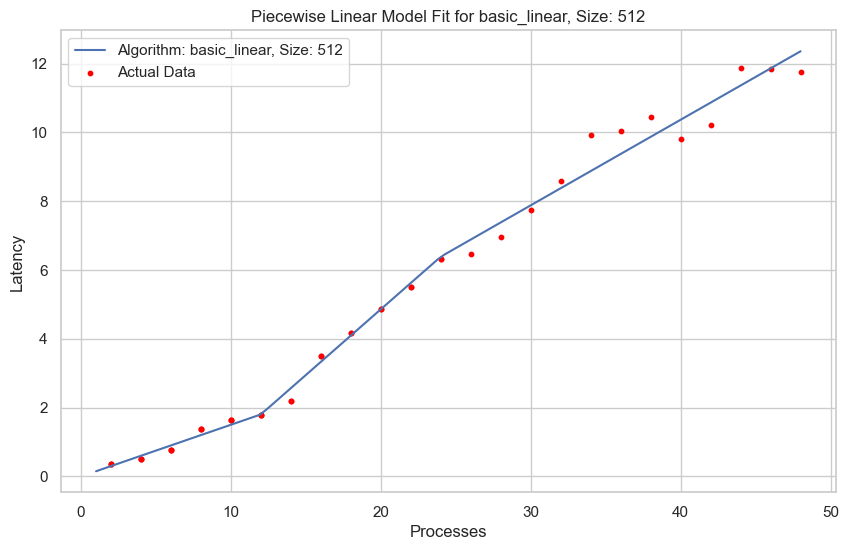

In [68]:
# For each algorithm in the benchmark data (df_benchmark), compare and plot the latencies for each mapping type:
# <= 12 processes for Core mapping
# <= 24 processes for Socket mapping
# <= 48 processes for Node mapping
# for a fixed messages size of 2, 512, 262144, 1048576
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pwlf

# Load performance data from each mapping
df_core_perf = pd.read_csv('../performance_test_core/performance_core.csv')
df_socket_perf = pd.read_csv('../performance_test_socket/performance_socket.csv')
df_node_perf = pd.read_csv('../performance_test_node/performance_node.csv')

# Load benchmark data
df_benchmark = pd.read_csv('thin_bcast_results.csv')

# Filter benchmark data for message sizes and process constraints
sizes = [2, 512, 262144, 1048576]
df_core = df_benchmark[(df_benchmark['Size'].isin(sizes)) & (df_benchmark['Processes'] <= 12)]
df_socket = df_benchmark[(df_benchmark['Size'].isin(sizes)) & (df_benchmark['Processes'] <= 24)]
df_node = df_benchmark[(df_benchmark['Size'].isin(sizes)) & (df_benchmark['Processes'] <= 48)]

# Add mapping type
df_core['Mapping'] = 'Core'
df_socket['Mapping'] = 'Socket'
df_node['Mapping'] = 'Node'

# Concatenate filtered benchmark data
df = pd.concat([df_core, df_socket, df_node])

# Prepare the data: Group by 'Algorithm', 'Size', 'Processes' and calculate mean latency
grouped = df.groupby(['Algorithm', 'Size', 'Mapping', 'Processes']).mean().reset_index()

# Initialize a dictionary to store models
models = {}

# Fit piecewise linear models
for name, group in grouped.groupby(['Algorithm', 'Size']):
    algorithm, size = name
    my_pwlf = pwlf.PiecewiseLinFit(group['Processes'], group['Latency'])

    # Define breakpoints for each mapping type dynamically based on available processes
    breaks = [group['Processes'].min()]
    if 'Core' in group['Mapping'].values:
        breaks.append(12)
    if 'Socket' in group['Mapping'].values:
        breaks.append(24)
    if 'Node' in group['Mapping'].values:
        breaks.append(48)
    breaks.append(group['Processes'].max())

    # Fit model
    my_pwlf.fit_with_breaks(np.unique(breaks))
    models[(algorithm, size)] = my_pwlf

# Example plot for a specific algorithm and size
algorithm_to_plot, size_to_plot = 'basic_linear', 512  # change as needed
plt.figure(figsize=(10, 6))
model = models.get((algorithm_to_plot, size_to_plot), None)
if model:
    x_hat = np.linspace(1, max(grouped['Processes']), 100)
    y_hat = model.predict(x_hat)
    plt.plot(x_hat, y_hat, label=f'Algorithm: {algorithm_to_plot}, Size: {size_to_plot}')
    actual_data = grouped[(grouped['Algorithm'] == algorithm_to_plot) & (grouped['Size'] == size_to_plot)]
    plt.scatter(actual_data['Processes'], actual_data['Latency'], color='red', s=10, label='Actual Data')
    plt.title(f'Piecewise Linear Model Fit for {algorithm_to_plot}, Size: {size_to_plot}')
    plt.xlabel('Processes')
    plt.ylabel('Latency')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No data available for this algorithm and size.")
